In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import os
import re
from copy import deepcopy
import sys
from typing import List, Dict, Tuple, Union, Optional, Any
import torch
from collections import defaultdict
from IPython.display import display

# mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12

In [2]:
fft_data = { num_tasks: pd.read_csv(f'fft_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}
lora_data = { num_tasks: pd.read_csv(f'lora_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}
l_lora_data = { num_tasks: pd.read_csv(f'l_lora_task_addition_num-tasks={num_tasks}.csv') for num_tasks in range(2, 8)}

In [3]:
fft_data[2]

,scaling_factor,dataset:0,dataset:1,glue-cola,glue-mnli,glue-mrpc,glue-qqp,glue-rte,glue-sst2,glue-stsb
0,0.00,glue-cola,glue-mnli,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN
1,0.05,glue-cola,glue-mnli,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN
2,0.10,glue-cola,glue-mnli,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN
3,0.15,glue-cola,glue-mnli,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN
4,0.20,glue-cola,glue-mnli,0.042186,0.0,0.0,0.0,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
436,0.80,glue-sst2,glue-stsb,0.000000,0.0,0.0,0.0,0.0,0.927752,0.879889
437,0.85,glue-sst2,glue-stsb,0.000000,0.0,0.0,0.0,0.0,0.928899,0.881823
438,0.90,glue-sst2,glue-stsb,0.000000,0.0,0.0,0.0,0.0,0.932339,0.882700
439,0.95,glue-sst2,glue-stsb,0.000000,0.0,0.0,0.0,0.0,0.930046,0.884876


In [4]:
def get_row_mean(row, col_names: List[str] = [
    "glue-cola",
    "glue-mnli",
    "glue-mrpc",
    "glue-qqp",
    "glue-rte",
    "glue-sst2",
    "glue-stsb",
]):
    zero_if_nan = lambda x: 0 if np.isnan(x) else x
    s = 0
    for col in col_names:
        s += zero_if_nan(row[col])
    return s / len(col_names)

In [5]:
def get_max_row_mean(data):
    results = defaultdict(lambda: list())
    for num_tasks in data.keys():
        group = data[num_tasks].groupby([f'dataset:{i}' for i in range(num_tasks)])
        for g in group:
            tasks = g[0]
            max_mean = float('-inf')
            max_index = 0
            for i, row in g[1].iterrows():
                mean = get_row_mean(row)
                if mean > max_mean:
                    max_mean = mean
                    max_index = i
            row = deepcopy(data[num_tasks].iloc[max_index])
            row.loc['mean'] = max_mean
            results[num_tasks].append(row)
        results[num_tasks] = pd.DataFrame(results[num_tasks])
    return results

In [6]:
for data in [fft_data, lora_data, l_lora_data]:
    results = get_max_row_mean(data)
    for num_tasks in results:
        print(num_tasks, len(results[num_tasks]))
    print()

2 21
3 35
4 35
5 21
6 7
7 1

2 21
3 35
4 35
5 21
6 7
7 1

2 21
3 35
4 35
5 21
6 7
7 1



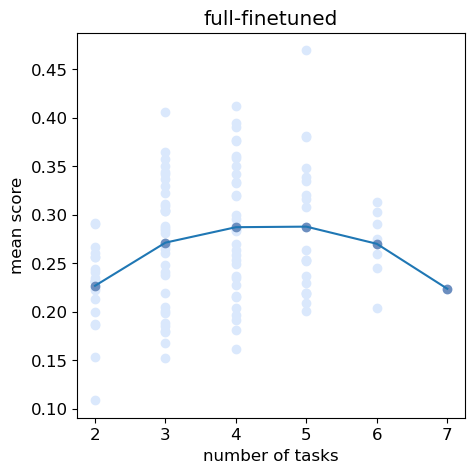

In [13]:
title = 'full-finetuned'
data = fft_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()

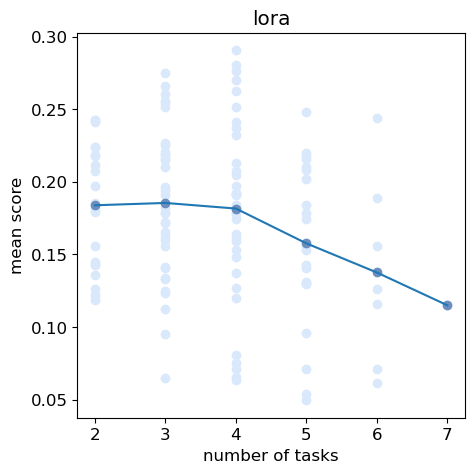

In [14]:
title = 'lora'
data = lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()

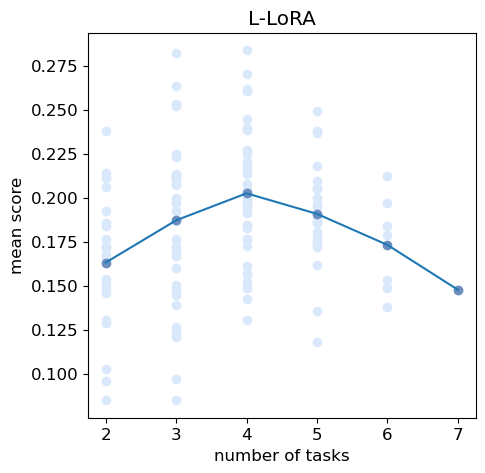

In [15]:
title = 'L-LoRA'
data = l_lora_data
# --------------
results = get_max_row_mean(data)
# for num_tasks in results:
#     print(num_tasks)
#     display(results[num_tasks])

fig, axes = plt.subplots(1,1,figsize=(5,5), squeeze=False)
ax: plt.Axes = axes[0,0]
Y_mean = []
for num_tasks in results:
    Y = np.array(results[num_tasks]['mean'])
    X = np.ones_like(Y) * num_tasks
    Y_mean.append(Y.mean())
    ax.scatter(X, Y, color = '#DAE8FC')
    ax.scatter([num_tasks], [Y.mean()], color = '#6C8EBF')
ax.plot(np.array(list(results.keys())), np.array(Y_mean))

ax.set_title(title)
ax.set_xlabel('number of tasks')
ax.set_ylabel('mean score')
plt.show()